In [95]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [96]:
warnings.filterwarnings('ignore', category=FutureWarning)

sns.set(style="whitegrid")
%matplotlib inline

# Understanding the problem

The aim of this competition is to predict the Severity Impairment Index (sii), which measures the level of problematic internet use among children and adolescents, based on physical activity data and other features.

sii is derived from `PCIAT-PCIAT_Total`, the sum of scores from the Parent-Child Internet Addiction Test (PCIAT: 20 questions, scored 0-5).

Target Variable (sii) is defined as:
- 0: None (PCIAT-PCIAT_Total from 0 to 30)
- 1: Mild (PCIAT-PCIAT_Total from 31 to 49)
- 2: Moderate (PCIAT-PCIAT_Total from 50 to 79)
- 3: Severe (PCIAT-PCIAT_Total 80 and more)

sii is an ordinal categorical variable with four levels.

There are 3 popular approaches we can use:

1. Ordinal classification (ordinal logistic regression, models with custom ordinal loss functions)
2. Multiclass classification (treat sii as a nominal categorical variable without considering the order)
3. Regression (ignore the discrete nature of categories and treat sii as a continuous variable, then round prediction)


Also, another strategy involves predicting responses to each question of the Parent-Child Internet Addiction Test: i.e. pedict individual question scores as separate targets, sum the predicted scores to get the `PCIAT-PCIAT_Total` and map predictions to the corresponding sii category. But this method may seem a bit difficult for someone who has no knowledge of the related field


# Explore Data

In [97]:
train = pd.read_csv('res/train.csv')
test = pd.read_csv('res/test.csv')
data_dict = pd.read_csv('res/data_dictionary.csv')

### Train data

In [98]:
display(train.head())
print(f"Train shape: {train.shape}")

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Train shape: (3960, 82)


### Test data

In [99]:
display(test.head())
print(f"Test shape: {test.shape}")

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Test shape: (20, 59)


# SII and PCIAT

Let's identify the features that are related to the target variable and that are not present in the test set.

**Parent-Child Internet Addiction Test (PCIAT):** contains 20 items (`PCIAT-PCIAT_01` to `PCIAT-PCIAT_20`), each assessing a different aspect of a child's behavior related to internet use. The items are answered on a scale (from 0 to 5), and the total score provides an indication of the severity of internet addiction.

We have season of participation in `PCIAT-Season` and total Score in `PCIAT-PCIAT_Total`; so there are 22 PCIAT test-related columns in total.

`PCIAT-PCIAT_Total` align with the corresponding sii categories, we will calculat its minimum and maximum scores for each sii category:

In [100]:
pciat_min_max = train.groupby('sii')['PCIAT-PCIAT_Total'].agg(['min', 'max'])
pciat_min_max = pciat_min_max.rename(
    columns={'min': 'Minimum PCIAT total Score', 'max': 'Maximum total PCIAT Score'}
)
pciat_min_max

,Minimum PCIAT total Score,Maximum total PCIAT Score
sii,,
0.0,0.0,30.0
1.0,31.0,49.0
2.0,50.0,79.0
3.0,80.0,93.0


In [101]:
data_dict[data_dict['Field'] == 'PCIAT-PCIAT_Total']['Value Labels'].iloc[0]

'Severity Impairment Index: 0-30=None; 31-49=Mild; 50-79=Moderate; 80-100=Severe'

### Check missing answers

Below We recalculate the SII based on `PCIAT_Total` and the maximum possible score if missing values were answered (5 points), ensuring that the recalculated SII meets the intended thresholds even with some missing answers.

In [102]:
# Define PCIAT_cols as a list of relevant column names
PCIAT_cols = [f'PCIAT-PCIAT_{i:02d}' for i in range(1, 21)]

# Function to recalculate sii
def recalculate_sii(row):
    if pd.isna(row['PCIAT-PCIAT_Total']):
        return np.nan
    max_possible = row['PCIAT-PCIAT_Total'] + row[PCIAT_cols].isna().sum() * 5
    if row['PCIAT-PCIAT_Total'] <= 30 and max_possible <= 30:
        return 0
    elif 31 <= row['PCIAT-PCIAT_Total'] <= 49 and max_possible <= 49:
        return 1
    elif 50 <= row['PCIAT-PCIAT_Total'] <= 79 and max_possible <= 79:
        return 2
    elif row['PCIAT-PCIAT_Total'] >= 80 and max_possible >= 80:
        return 3
    return np.nan

# Apply the function to recalculate sii
train['recalc_sii'] = train.apply(recalculate_sii, axis=1)

Verification of rows with different original and recalculated SII:

In [103]:
mismatch_rows = train[
    (train['recalc_sii'] != train['sii']) & train['sii'].notna()
]

mismatch_rows[PCIAT_cols + [
    'PCIAT-PCIAT_Total', 'sii', 'recalc_sii'
]].style.applymap(
    lambda x: 'background-color: #3366cc' if pd.isna(x) else ''
)

,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,sii,recalc_sii
24,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,nan,2.000000,30.000000,0.000000,nan
93,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,nan
104,5.000000,2.000000,4.000000,2.000000,nan,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,45.000000,1.000000,nan
141,1.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000,nan,0.000000,2.000000,0.000000,26.000000,0.000000,nan
142,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,1.000000,26.000000,0.000000,nan
270,3.000000,3.000000,4.000000,2.000000,4.000000,2.000000,1.000000,3.000000,2.000000,2.000000,4.000000,0.000000,2.000000,1.000000,4.000000,nan,2.000000,3.000000,4.000000,2.000000,48.000000,1.000000,nan
368,2.000000,3.000000,4.000000,2.000000,5.000000,1.000000,2.000000,nan,nan,nan,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,nan,nan,31.000000,1.000000,nan
592,3.000000,0.000000,3.000000,0.000000,3.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000,0.000000,1.000000,nan,nan,1.000000,2.000000,1.000000,1.000000,0.000000,21.000000,0.000000,nan
724,3.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000,nan,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,1.000000,29.000000,0.000000,nan
877,5.000000,5.000000,5.000000,4.000000,5.000000,0.000000,5.000000,5.000000,5.000000,5.000000,4.000000,nan,4.000000,5.000000,5.000000,1.000000,5.000000,0.000000,5.000000,5.000000,78.000000,2.000000,nan


For now, we can conclude that the SII score is sometimes incorrect.


Also, all columns have a substantial proportion of missing values, except id and the three basic demographic columns for sex, age and season of enrollment. Even the target sii has missing values:

In [104]:
def missing_data_summary(df):
    """
    This function summarizes missing data,
    showing count and percentage of missing values for each column.
    """
    return (pd.DataFrame(df.isna().sum())
            .reset_index()
            .rename(columns={'index': 'Column', 0: 'mis_count'})
            .query('mis_count > 0')
            .assign(Missing_Percentage=lambda x: x['mis_count'] / df.shape[0] * 100)
            .sort_values('mis_count', ascending=False)
            .reset_index(drop=True))
common_columns = train.columns.intersection(test.columns)
df_train = train[common_columns].copy()
if 'sii' in train.columns:
    df_train['sii'] = train['sii']
missing_data_summary(df_train)

,Column,mis_count,Missing_Percentage
0,PAQ_A-Season,3485,88.005051
1,PAQ_A-PAQ_A_Total,3485,88.005051
2,Fitness_Endurance-Time_Mins,3220,81.313131
3,Fitness_Endurance-Time_Sec,3220,81.313131
4,Fitness_Endurance-Max_Stage,3217,81.237374
5,Physical-Waist_Circumference,3062,77.323232
6,FGC-FGC_GSND_Zone,2898,73.181818
7,FGC-FGC_GSD_Zone,2897,73.156566
8,FGC-FGC_GSD,2886,72.878788
9,FGC-FGC_GSND,2886,72.878788


### Plot distribution of the target variable

The target variable sii is ordinal and imbalanced, with the majority of participants having a score of 0 (None) or 1 (Mild), 2 (Moderate) 14% and only 1.2% for 3 (Severe). This will heavily affect the model accuracy for minority class like 2 and 3

The distribution is as follows:

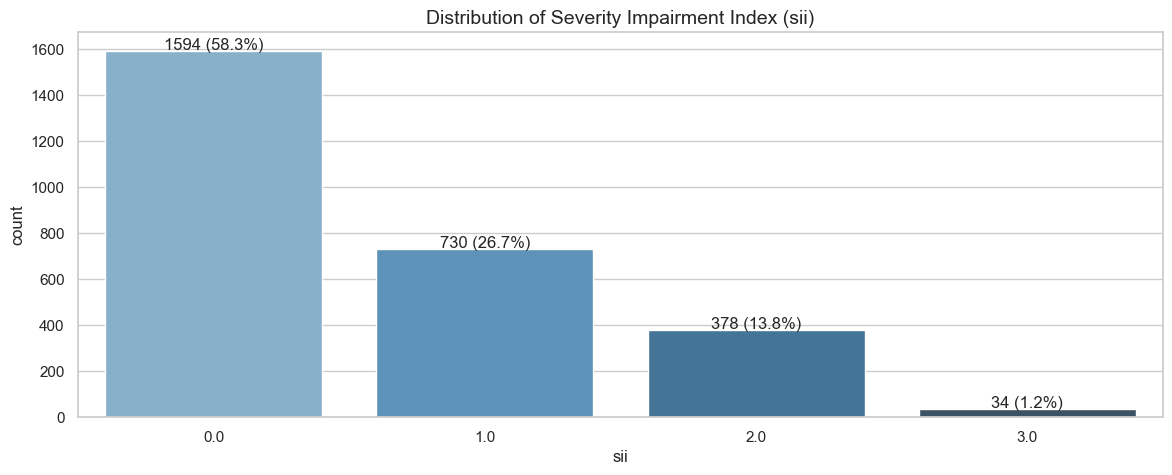

In [105]:
# Calculate the value counts and percentages
sii_counts = train['sii'].value_counts().reset_index()
sii_counts.columns = ['sii', 'count']
total = sii_counts['count'].sum()
sii_counts['percentage'] = (sii_counts['count'] / total) * 100

# Create the plot
fig, ax = plt.subplots(figsize=(14, 5))

# Plot the bar chart
sns.barplot(x='sii', y='count', data=sii_counts, palette='Blues_d', ax=ax)
ax.set_title('Distribution of Severity Impairment Index (sii)', fontsize=14)

# Annotate the bars with counts and percentages
for p in ax.patches:
    height = p.get_height()
    percentage = sii_counts.loc[sii_counts['count'] == height, 'percentage'].values[0]
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 5, f'{int(height)} ({percentage:.1f}%)',
        ha="center", fontsize=12
    )

plt.show()

# Addition info

The study participants are between 5 and 22 years old. There are twice as many boys as girls.

The four seasons of enrollment have similar frequencies

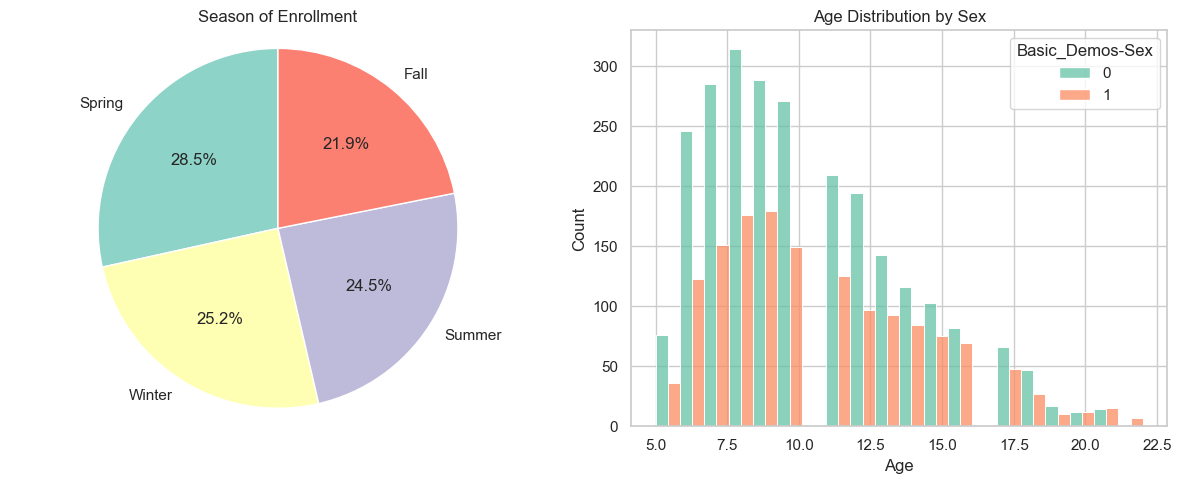

In [106]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Season of Enrollment
season_counts = train['Basic_Demos-Enroll_Season'].value_counts(dropna=False)

axes[0].pie(
    season_counts, labels=season_counts.index,
    autopct='%1.1f%%', startangle=90,
    colors=sns.color_palette("Set3")
)
axes[0].set_title('Season of Enrollment')
axes[0].axis('equal')

# Age Distribution by Sex
sns.histplot(
    data=train, x='Basic_Demos-Age',
    hue='Basic_Demos-Sex', multiple='dodge',
    palette="Set2", bins=20, ax=axes[1]
)
axes[1].set_title('Age Distribution by Sex')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

Boys have a slightly higher risk of internet addiction than girls

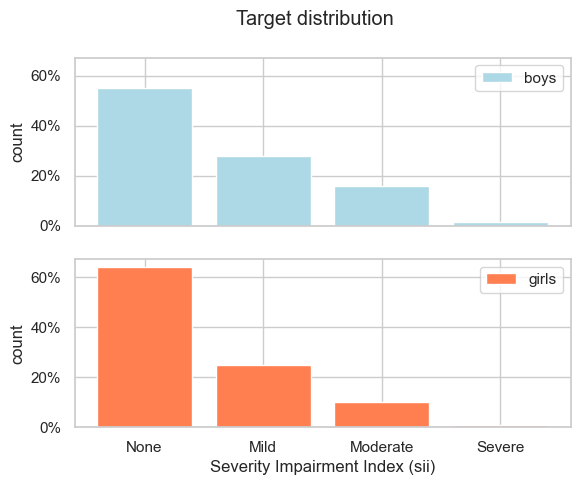

In [107]:
from matplotlib.ticker import PercentFormatter

# Define target_labels
target_labels = ['None', 'Mild', 'Moderate', 'Severe']

# Create the subplots
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

# Loop through each sex (0 for boys, 1 for girls)
for sex in range(2):
    ax = axs.ravel()[sex]
    vc = train[train['Basic_Demos-Sex'] == sex]['sii'].value_counts().sort_index()
    ax.bar(vc.index,
           vc.values / vc.values.sum(),
           color=['lightblue', 'coral'][sex],
           label=['boys', 'girls'][sex])
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(target_labels)
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set_ylabel('count')
    ax.legend()

# Set the title and labels
plt.suptitle('Target distribution')
axs.ravel()[1].set_xlabel('Severity Impairment Index (sii)')
plt.show()

# A simple classification model

As díscussed earlier, we have three main approaches to tackle this problem:
1. Ordinal classification
2. Multiclass classification
3. Regression

For this initial model, we will use the second approach: Multiclass classification.
Because the target variable is cateogorical with 4 levels. Multiclass classification is designed to handle such problems where the goal is to classify instances into one of several categories.

Also Multiclass classification can be applied using a variety of algorithms (e.g., Random Forest, XGBoost, LightGBM), allowing for flexibility in model selection and the ability to leverage ensemble methods for improved performance.



## But first, let's preprocess the data

In [108]:
train = pd.read_csv('res/train.csv')
df_test = pd.read_csv('res/test.csv')

# Preprocessing: Select common columns
common_columns = train.columns.intersection(df_test.columns)
df_train = train[common_columns].copy()
if 'sii' in train.columns:
    df_train['sii'] = train['sii']
# Drop rows with missing target values
df_train = df_train.dropna(subset=['sii'])

It is important that we select only the samples where the target sii is known and that we drop all PCIAT columns. We don't use the accelerometer data for this model.

In [109]:
# Remove ID column
df_train.drop('id', axis=1, inplace=True)

# Separate numerical and categorical columns
cat_columns = df_train.select_dtypes(include=['object', 'category']).columns
num_columns = df_train.select_dtypes(include=['int64', 'float64']).columns.drop('sii')

Drop id column and separate numerical and categorical columns for appropriate preprocessing. The sii column is excluded from the numerical columns as it is the target variable.

In [110]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

Handles numerical features by imputing missing values with the mean and scaling the features.

Scaling transforms the numerical features to a standard scale, typically with a mean of 0 and a standard deviation of 1. This helps in improving the performance of machine learning algorithms that are sensitive to the scale of input data.

In [111]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

Handles categorical features by imputing missing values with 'missing' and applying one-hot encoding to converts categorical variables into a binary matrix representation, ensures that the categorical data is transformed into a format suitable for the machine learning algorithms.

In [112]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_columns),
        ('cat', cat_transformer, cat_columns)
    ]
)

# Create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=123, n_estimators=100))
])
"..."
"..."
"..."

'...'

## Random Forest Classifier (V1)
Random Forest algorithm is a powerful tree learning technique in Machine Learning. It works by creating a number of Decision Trees during the training phase. Each tree is constructed using a random subset of the data set to measure a random subset of features in each partition. This randomness introduces variability among individual trees, reducing the risk of overfitting and improving overall prediction performance. Additionally, it is well-suited for multi-class classification problems. Our initial implementation using only the Random Forest classifier performed quite poorly, with score 0.150 on private test and 0.254 on public test.

As we can see below, the model is not performing well, with low precision and recall for the minority classes (2 and 3). This is likely due to the imbalanced nature of the target variable, which has a majority of samples in classes 0 and 1.


In [113]:
# Separate features and target
X = df_train.drop('sii', axis=1)
y = df_train['sii']

# Train-test split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=123)

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Evaluate the model
y_valid_pred = pipeline.predict(X_valid)

# Print classification report
print("Validation Performance:\n", classification_report(y_valid, y_valid_pred))

# Preprocess and predict on the test set
df_test_preprocessed = pipeline['preprocessor'].transform(df_test)
y_test_pred = pipeline['classifier'].predict(df_test_preprocessed)

# Save predictions to CSV
df_submit = df_test[['id']].copy()
df_submit['sii'] = y_test_pred
df_submit.to_csv('submission.csv', index=False)

Validation Performance:
               precision    recall  f1-score   support

         0.0       0.64      0.89      0.75       393
         1.0       0.42      0.23      0.30       196
         2.0       0.32      0.12      0.18        90
         3.0       0.00      0.00      0.00         5

    accuracy                           0.59       684
   macro avg       0.35      0.31      0.31       684
weighted avg       0.53      0.59      0.54       684



P:\Code\Python\INT3405E_56_ML_Child-Mind-Institute\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
P:\Code\Python\INT3405E_56_ML_Child-Mind-Institute\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
P:\Code\Python\INT3405E_56_ML_Child-Mind-Institute\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera


## SMOTE (V2)
The Synthetic Minority Over-Sampling Technique (SMOTE) is a powerful method used to handle class imbalance in datasets. SMOTE handles this issue by generating samples of minority classes to make the class distribution balanced. SMOTE works by generating synthetic examples in the feature space of the minority class. Using SMOTE to address this imbalance dataset is essential for enhancing the model’s performance. In the second version we adding SMOTE to solve the unbalance data problem, it significantly boosts the model's performance, increasing from 0.15 to over 0.361 on private test and from 0.254 to 0.361 on public test.

Below is the result, the model is performing better, with improved precision and recall for the minority classes (2 and 3). Although the model is still not perfect, we still need to improve it further.


In [114]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

train = pd.read_csv('res/train.csv')
df_test = pd.read_csv('res/test.csv')

# Preprocessing: Select common columns
common_columns = train.columns.intersection(df_test.columns)
df_train = train[common_columns].copy()
if 'sii' in train.columns:
    df_train['sii'] = train['sii']

# Remove ID column
df_train.drop('id', axis=1, inplace=True)

# Separate numerical and categorical columns
cat_columns = df_train.select_dtypes(include=['object', 'category']).columns
num_columns = df_train.select_dtypes(include=['int64', 'float64']).columns.drop('sii')

# Define preprocessing for numerical and categorical features
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_columns),
        ('cat', cat_transformer, cat_columns)
    ]
)

# Drop rows with missing target values
df_train = df_train.dropna(subset=['sii'])

# Separate features and target
X = df_train.drop('sii', axis=1)
y = df_train['sii']

# Train-test split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=123)

# Preprocess training data
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Apply SMOTE
smote = SMOTE(random_state=123)
X_resampled, y_resampled = smote.fit_resample(X_train_preprocessed, y_train)

# Train a classifier using resampled data
classifier = RandomForestClassifier(random_state=123, n_estimators=100)
classifier.fit(X_resampled, y_resampled)

# Preprocess validation data and evaluate the model
X_valid_preprocessed = preprocessor.transform(X_valid)
y_valid_pred = classifier.predict(X_valid_preprocessed)

print("Validation Performance:\n", classification_report(y_valid, y_valid_pred))

# Preprocess and predict on the test set
df_test_preprocessed = preprocessor.transform(df_test)
y_test_pred = classifier.predict(df_test_preprocessed)

# Save predictions to CSV
df_submit = df_test[['id']].copy()
df_submit['sii'] = y_test_pred
df_submit.to_csv('submission.csv', index=False)


Validation Performance:
               precision    recall  f1-score   support

         0.0       0.69      0.79      0.74       393
         1.0       0.39      0.32      0.35       196
         2.0       0.30      0.27      0.28        90
         3.0       1.00      0.20      0.33         5

    accuracy                           0.58       684
   macro avg       0.60      0.39      0.43       684
weighted avg       0.56      0.58      0.56       684




## GridSearchCV
GridSearchCV is a powerful tool in Scikit-learn for hyperparameter tuning, designed to find the best parameter combination for a given machine learning model. It performs an exhaustive search over a specified parameter grid, evaluating each combination using cross-validation to ensure robust performance. The tool uses the provided scoring metric to determine the best-performing parameters and can automatically refit the model using those parameters for final use.

Balancing Model Complexity: to prevent the model from overfitting and underfitting, we use three sets of parameters in the grid search. Each set represents different levels of model complexity: one with a smaller number of trees and shallower depths to prevent overfitting, another with larger numbers of trees and deeper depths to capture more complexity, and a third that strikes a balance between the two.

In version 3, by adding GridSearchCV we observed an improvement in performance, with the score increasing from 0.361 to 0.423 on public test. However, we find it overfitting after private score significantly dropped to just 0.332.



We believe that one of the reason the model is overfitting because of the random seed we use. When we use different random seed, the model will perform differently, usually not as good as the seed we use in the previous version. But it still improve the model performance compare to not using GridSearchCV. Here is some topic about the affection of random seed.
https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/discussion/552180
https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/discussion/552625

In [ ]:
# Define the parameter grid for RandomForestClassifier
param_grid = {
    'classifier__n_estimators': [50, 100, 150],  # Number of trees in the forest
    'classifier__max_depth': [None, 10, 20],    # Maximum depth of the trees
    'classifier__min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'classifier__min_samples_leaf': [1, 2, 4]     # Minimum samples required at each leaf node
}
# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)